In [4]:
import trimesh

scene = trimesh.Scene()

In [1]:
import torch
import numpy as np
import os
import shutil
from tqdm import tqdm
import yaml

import sys
import os
curr_dir = os.getcwd()
if 's94zalek_hpc' in curr_dir:
    user_name = 's94zalek_hpc'
else:
    user_name = 's94zalek'
sys.path.append(f'/home/{user_name}/shape_matching')

# models
from my_code.models.diag_conditional import DiagConditionedUnet
from diffusers import DDPMScheduler

# training / evaluation
from torch.utils.tensorboard import SummaryWriter
from my_code.diffusion_training_sign_corr.train_model import train_epoch
from my_code.diffusion_training_sign_corr.validate_model import validate_epoch

import my_code.diffusion_training_sign_corr.data_loading as data_loading

from my_code.datasets.surreal_cached_train_dataset import SurrealTrainDataset
import networks.diffusion_network as diffusion_network



# configuration
experiment_name = 'test_signCorr_withAug_evecs_32'
checkpoint_name = 'checkpoint_99'

### config
exp_base_folder = f'/home/s94zalek_hpc/shape_matching/my_code/experiments/{experiment_name}'
with open(f'{exp_base_folder}/config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)


### model
model = DiagConditionedUnet(config["model_params"]).to('cuda')
model.load_state_dict(torch.load(f"{exp_base_folder}/checkpoints/{checkpoint_name}.pt"))
model = model.to('cuda')
 
### Sign correction network
sign_corr_net = diffusion_network.DiffusionNet(
    in_channels=config["model_params"]["sample_size"],
    out_channels=config["model_params"]["sample_size"] // config["evecs_per_support"],
    cache_dir=None,
    input_type=config["net_input_type"],
    k_eig=128,
    n_block=6
    ).to('cuda')
sign_corr_net.load_state_dict(
    torch.load(config["sign_net_path"]))


### sample the model
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2',
                                clip_sample=True) 

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
### test dataset
dataset_name = 'FAUST_r'

test_dataset = data_loading.get_val_dataset(
    dataset_name, 'train', 128
    )[1]
sign_corr_net.cache_dir = test_dataset.lb_cache_dir

# return the subset
# subset_indices = list(range(len(test_dataset))) #[10:]
# test_dataset = torch.utils.data.Subset(test_dataset, subset_indices)


  0%|                                                                                                            | 0/80 [00:00<?, ?it/s]

0
Geo error GT: 1.41
Geo error GT corr: 1.41
Geo error est: 5.20
MSE fmap: 13.630
MSE abs fmap: 3.595


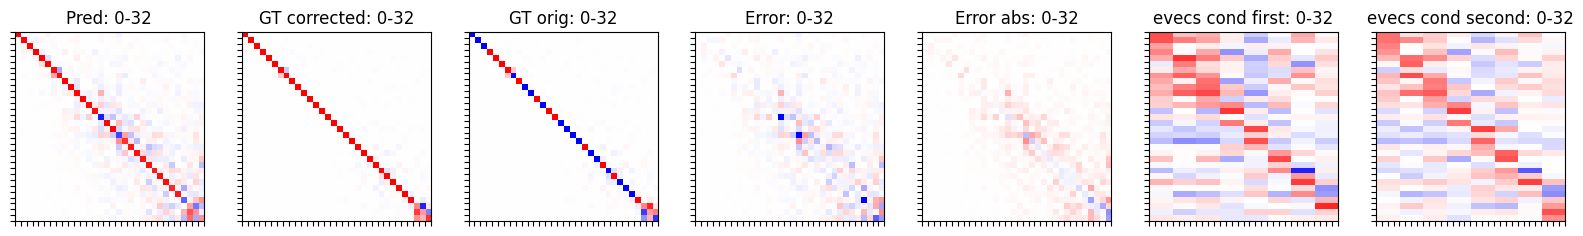

  1%|█▎                                                                                                  | 1/80 [00:15<20:26, 15.52s/it]

1
Geo error GT: 1.80
Geo error GT corr: 1.80
Geo error est: 4.67
MSE fmap: 10.643
MSE abs fmap: 5.130


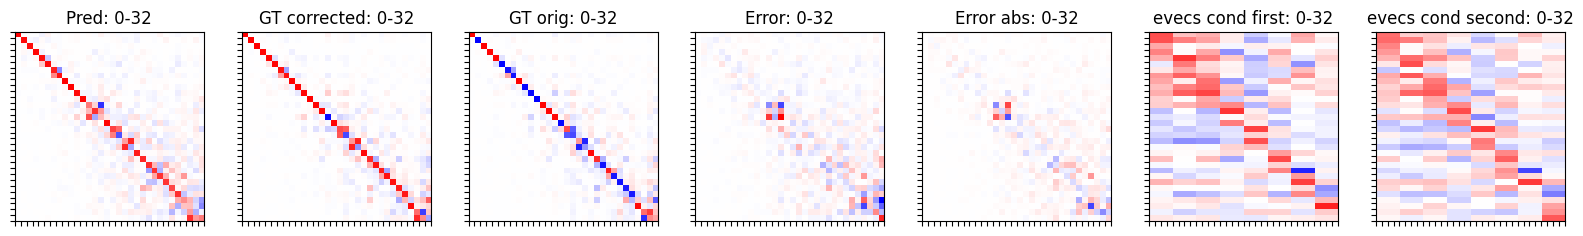

  2%|██▌                                                                                                 | 2/80 [00:30<19:25, 14.95s/it]

2
Geo error GT: 1.79
Geo error GT corr: 1.79
Geo error est: 3.76
MSE fmap: 8.173
MSE abs fmap: 3.434


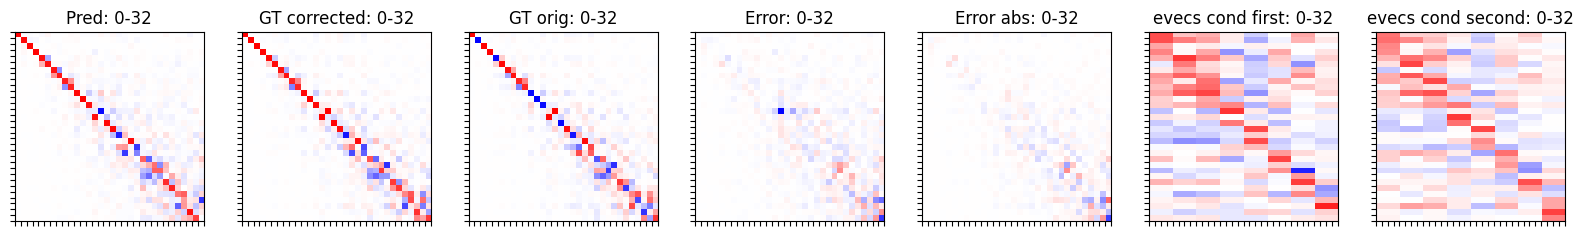

  4%|███▊                                                                                                | 3/80 [00:44<19:04, 14.87s/it]

3
Geo error GT: 1.84
Geo error GT corr: 1.84
Geo error est: 22.77
MSE fmap: 34.551
MSE abs fmap: 9.434


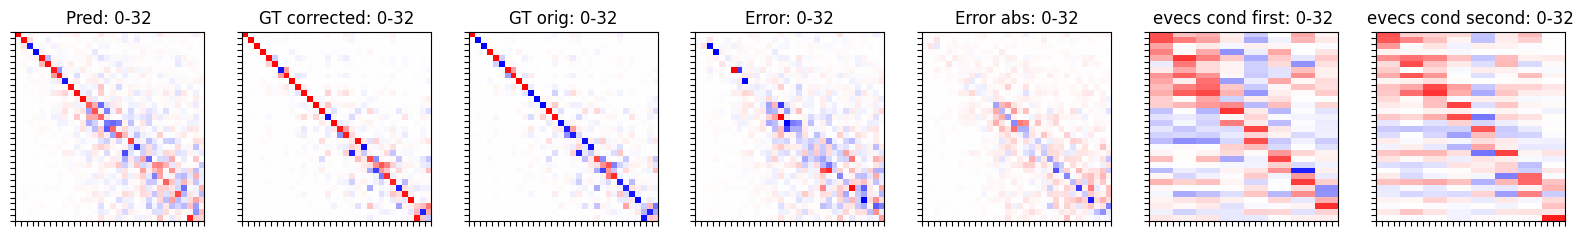

  4%|███▊                                                                                                | 3/80 [00:59<25:25, 19.82s/it]

Mean geo err: 9.10
Median geo err: 4.67
Min geo err: 3.76
Max geo err: 22.77

Mean ratio: 5.20
Median ratio: 2.60
Min ratio: 2.10
Max ratio: 12.41


In [3]:
import utils.fmap_util as fmap_util
import metrics.geodist_metric as geodist_metric
from my_code.sign_canonicalization.training import predict_sign_change
import matplotlib.pyplot as plt
import my_code.utils.plotting_utils as plotting_utils

tqdm._instances.clear()

l = 0
h = 32

num_evecs = config["model_params"]["sample_size"]

ratios = []
geo_errs = []

Cxy_est_list = []
C_gt_xy_corr_list = []


data_range = tqdm(range(len(test_dataset)))

for i in data_range:

    data = test_dataset[i]
    
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # device = 'cpu'
    
    verts_first = data['first']['verts'].unsqueeze(0).to(device)
    verts_second = data['second']['verts'].unsqueeze(0).to(device)
    
    faces_first = data['first']['faces'].unsqueeze(0).to(device)
    faces_second = data['second']['faces'].unsqueeze(0).to(device)

    evecs_first = data['first']['evecs'][:, :num_evecs].unsqueeze(0).to(device)
    evecs_second = data['second']['evecs'][:, :num_evecs].unsqueeze(0).to(device)
    
    evals_first = data['first']['evals'][:num_evecs]
    evals_second = data['second']['evals'][:num_evecs]

    corr_first = data['first']['corr']
    corr_second = data['second']['corr']


    # predict the sign change
    with torch.no_grad():
        sign_pred_first, support_vector_norm_first, _ = predict_sign_change(
            sign_corr_net, verts_first, faces_first, evecs_first, 
            evecs_cond=None, input_type=sign_corr_net.input_type,
            # mass=None, L=None, evals=None, evecs=None, gradX=None, gradY=None
            mass=data['first']['mass'].unsqueeze(0), L=data['first']['L'].unsqueeze(0),
            evals=data['first']['evals'].unsqueeze(0), evecs=data['first']['evecs'].unsqueeze(0),
            gradX=data['first']['gradX'].unsqueeze(0), gradY=data['first']['gradY'].unsqueeze(0)
            )
        sign_pred_second, support_vector_norm_second, _ = predict_sign_change(
            sign_corr_net, verts_second, faces_second, evecs_second, 
            evecs_cond=None, input_type=sign_corr_net.input_type,
            # mass=None, L=None, evals=None, evecs=None, gradX=None, gradY=None
            mass=data['second']['mass'].unsqueeze(0), L=data['second']['L'].unsqueeze(0),
            evals=data['second']['evals'].unsqueeze(0), evecs=data['second']['evecs'].unsqueeze(0),
            gradX=data['second']['gradX'].unsqueeze(0), gradY=data['second']['gradY'].unsqueeze(0)
            )

    # correct the evecs
    evecs_first_corrected = evecs_first.cpu()[0] * torch.sign(sign_pred_first).cpu()
    evecs_first_corrected_norm = evecs_first_corrected / torch.norm(evecs_first_corrected, dim=0, keepdim=True)
    
    evecs_second_corrected = evecs_second.cpu()[0] * torch.sign(sign_pred_second).cpu()
    evecs_second_corrected_norm = evecs_second_corrected / torch.norm(evecs_second_corrected, dim=0, keepdim=True)
    
    # product with support
    evecs_cond_first = evecs_first_corrected_norm.transpose(0, 1) @ support_vector_norm_first[0].cpu()
    evecs_cond_second = evecs_second_corrected_norm.transpose(0, 1) @ support_vector_norm_second[0].cpu()

    # gt corrected fmap
    C_gt_xy_corr = torch.linalg.lstsq(
        evecs_second_corrected[corr_second],
        evecs_first_corrected[corr_first]
        ).solution
    
    # gt original fmap
    C_gt_xy = torch.linalg.lstsq(
        evecs_second.cpu()[0, corr_second],
        evecs_first.cpu()[0, corr_first]
        ).solution
    
    
    ###############################################
    # Conditioning
    ###############################################

    conditioning = torch.tensor([])
    
    if 'evals' in config["conditioning_types"]:
        eval = evals_second.unsqueeze(0)
        eval = torch.diag_embed(eval)
        conditioning = torch.cat((conditioning, eval), 0)
    
    if 'evals_inv' in config["conditioning_types"]:
        eval_inv = 1 / evals_second.unsqueeze(0)
        # replace elements > 1 with 1
        eval_inv[eval_inv > 1] = 1
        eval_inv = torch.diag_embed(eval_inv)
        conditioning = torch.cat((conditioning, eval_inv), 0)
    
    if 'evecs' in config["conditioning_types"]:
        evecs = torch.cat(
            (evecs_cond_first.unsqueeze(0), evecs_cond_second.unsqueeze(0)),
            0)
        conditioning = torch.cat((conditioning, evecs), 0)
    
    
    ###############################################
    # Sample the model
    ###############################################
    
    x_sampled = torch.rand(1, 1, model.model.sample_size, model.model.sample_size).to(device)
    y = conditioning.unsqueeze(0).to(device)    
    
    # print(x_sampled.shape, y.shape)
        
    # Sampling loop
    for t in noise_scheduler.timesteps:

        # Get model pred
        with torch.no_grad():
            residual = model(x_sampled, t,
                                conditioning=y
                                ).sample

        # Update sample with step
        x_sampled = noise_scheduler.step(residual, t, x_sampled).prev_sample

    Cxy_est = x_sampled[0][0].cpu()
    
    ###############################################
    # Evaluation
    ###############################################  
    
    # hard correspondence 
    p2p_gt = fmap_util.fmap2pointmap(
        C12=C_gt_xy,
        evecs_x=evecs_first.cpu()[0],
        evecs_y=evecs_second.cpu()[0],
        )
    p2p_corr_gt = fmap_util.fmap2pointmap(
        C12=C_gt_xy_corr,
        evecs_x=evecs_first_corrected,
        evecs_y=evecs_second_corrected,
        )
    p2p_est = fmap_util.fmap2pointmap(
        Cxy_est,
        evecs_x=evecs_first_corrected,
        evecs_y=evecs_second_corrected,
        )
    
    # distance matrices
    dist_x = torch.cdist(data['first']['verts'], data['first']['verts'])
    dist_y = torch.cdist(data['second']['verts'], data['second']['verts'])

    # geodesic error
    geo_err_gt = geodist_metric.calculate_geodesic_error(
        dist_x, data['first']['corr'], data['second']['corr'], p2p_gt, return_mean=False
        )  
    geo_err_corr_gt = geodist_metric.calculate_geodesic_error(
        dist_x, data['first']['corr'], data['second']['corr'], p2p_corr_gt, return_mean=False
        )
    geo_err_est = geodist_metric.calculate_geodesic_error(
        dist_x, data['first']['corr'], data['second']['corr'], p2p_est, return_mean=False
        )
    
    # mse between sampled and corrected fmap
    # mse_fmap = torch.nn.functional.mse_loss(C_gt_xy_corr, Cxy_est)
    mse_fmap = torch.sum((C_gt_xy_corr - Cxy_est) ** 2)
    mse_abs_fmap = torch.sum((C_gt_xy_corr.abs() - Cxy_est.abs()) ** 2)
    
    
    fig, axs = plt.subplots(1, 7, figsize=(20, 3))

    plotting_utils.plot_Cxy(fig, axs[0], Cxy_est,
                            f'Pred', l, h, show_grid=False, show_colorbar=False)
    plotting_utils.plot_Cxy(fig, axs[1], C_gt_xy_corr,
                            f'GT corrected', l, h, show_grid=False, show_colorbar=False)
    plotting_utils.plot_Cxy(fig, axs[2], C_gt_xy,
                            f'GT orig', l, h, show_grid=False, show_colorbar=False)
    plotting_utils.plot_Cxy(fig, axs[3], Cxy_est - C_gt_xy_corr,
                            f'Error', l, h, show_grid=False, show_colorbar=False)
    plotting_utils.plot_Cxy(fig, axs[4], Cxy_est.abs() - C_gt_xy_corr.abs(),
                            f'Error abs', l, h, show_grid=False, show_colorbar=False)
    plotting_utils.plot_Cxy(fig, axs[5], evecs_cond_first,
                            f'evecs cond first', l, h, show_grid=False, show_colorbar=False)
    plotting_utils.plot_Cxy(fig, axs[6], evecs_cond_second,
                            f'evecs cond second', l, h, show_grid=False, show_colorbar=False)
    
    print(i)
    print(f'Geo error GT: {geo_err_gt.mean() * 100:.2f}')
    print(f'Geo error GT corr: {geo_err_corr_gt.mean() * 100:.2f}')
    print(f'Geo error est: {geo_err_est.mean() * 100:.2f}')
    print(f'MSE fmap: {mse_fmap:.3f}')
    print(f'MSE abs fmap: {mse_abs_fmap:.3f}')
    
    # break
    plt.show()
    
    # print(f'{i:2d}) ratio {geo_err_est.mean() / geo_err_corr_gt.mean():.2f}')
    
    ratio_curr = geo_err_est.mean() / geo_err_corr_gt.mean()
    geo_err_curr = geo_err_est.mean() * 100
    
    ratios.append(ratio_curr)
    geo_errs.append(geo_err_curr)
    Cxy_est_list.append(Cxy_est)
    C_gt_xy_corr_list.append(C_gt_xy_corr)
    
    # data_range.set_description(
    #     f'Geo error est: {geo_err_curr:.2f}, '+\
    #     f'Mean {torch.tensor(geo_errs).mean():.2f}, '+\
    #     f'Median {torch.tensor(geo_errs).median():.2f}, '+\
    #     f'Ratio: {ratio_curr:.2f}, '+\
    #     f'Mean: {torch.tensor(ratios).mean():.2f}, '+\
    #     f'Median: {torch.tensor(ratios).median():.2f}'
    #     )
    
    if geo_err_est.mean() * 100 > 10:
        break
    
    # break
    

ratios = torch.tensor(ratios)
geo_errs = torch.tensor(geo_errs)
    
# print mean / median / min / max ratio and geo errs
# geo errs
print(f'Mean geo err: {geo_errs.mean():.2f}')
print(f'Median geo err: {geo_errs.median():.2f}')
print(f'Min geo err: {geo_errs.min():.2f}')
print(f'Max geo err: {geo_errs.max():.2f}')

print()
# ratios
print(f'Mean ratio: {ratios.mean():.2f}')
print(f'Median ratio: {ratios.median():.2f}')
print(f'Min ratio: {ratios.min():.2f}')
print(f'Max ratio: {ratios.max():.2f}')

In [ ]:
import my_code.utils.plotting_utils as plotting_utils

scene.geometry.clear()

plotting_utils.plot_p2p_map(
    scene,
    data['first']['verts'], data['first']['faces'],
    data['second']['verts'], data['second']['faces'],
    p2p_est
)

scene.show()

In [ ]:
cond_no_mass = evecs_second_corrected_norm.transpose(0, 1) @ support_vector_norm_second[0].cpu()

# mass_normalized = data['second']['mass'] / torch.norm(data['second']['mass'], dim=0, keepdim=True)
# cond_mass = evecs_second_corrected_norm.transpose(0, 1) @\
#     torch.diag(mass_normalized) @\
#         support_vector_norm_second[0].cpu()
    # torch.diag(data['second']['mass']) @\
        # support_vector_norm_second[0].cpu()

evecs_corr_mass = evecs_second_corrected_norm.transpose(0, 1) @\
    torch.diag(data['second']['mass'])
    
evecs_corr_mass_norm = evecs_corr_mass / torch.norm(evecs_corr_mass, dim=1, keepdim=True)

cond_mass = evecs_corr_mass_norm @ support_vector_norm_second[0].cpu()


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs_0 = axs[0].imshow(cond_no_mass)
plt.colorbar(axs_0, ax=axs[0])
axs[0].set_title('No mass')

axs_1 = axs[1].imshow(cond_mass)
plt.colorbar(axs_1, ax=axs[1])
axs[1].set_title('With mass')

plt.show()

In [23]:
torch.norm(data['second']['mass'])

tensor(0.0186)

In [19]:
mass = data['second']['mass'].unsqueeze(0)
# mass.shape
torch.diag_embed(mass)

tensor([[[1.1598e-04, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.4487e-04, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 3.5849e-05,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.3247e-05,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          3.2688e-05, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 3.5036e-05]]])

In [27]:
mass.sum()

tensor(1.)

In [13]:
ratios = torch.tensor(ratios)
geo_errs = torch.tensor(geo_errs)
    
# print mean / median / min / max ratio and geo errs
# geo errs
print(f'Mean geo err: {geo_errs.mean():.2f}')
print(f'Median geo err: {geo_errs.median():.2f}')
print(f'Min geo err: {geo_errs.min():.2f}')
print(f'Max geo err: {geo_errs.max():.2f}')

print()
# ratios
print(f'Mean ratio: {ratios.mean():.2f}')
print(f'Median ratio: {ratios.median():.2f}')
print(f'Min ratio: {ratios.min():.2f}')
print(f'Max ratio: {ratios.max():.2f}')

Mean geo err: 3.12
Median geo err: 2.87
Min geo err: 1.82
Max geo err: 26.28

Mean ratio: 1.51
Median ratio: 1.25
Min ratio: 1.02
Max ratio: 18.18


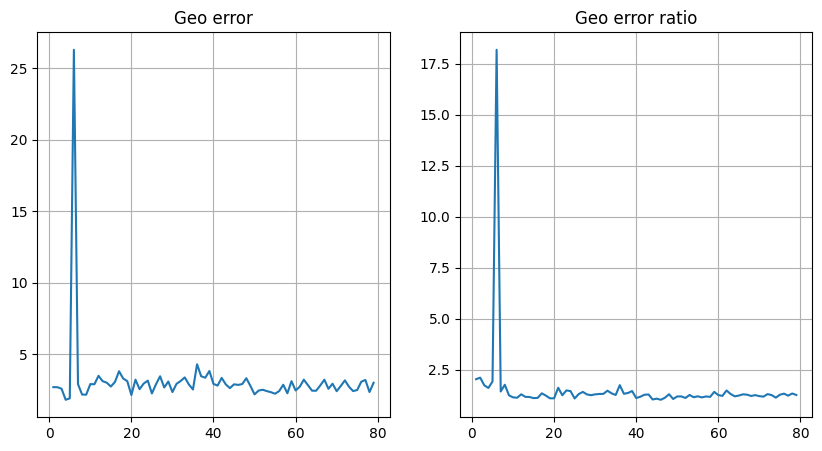

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
ax[0].plot(data_range, geo_errs)
ax[0].set_title('Geo error')
    
ax[1].plot(data_range, ratios)
ax[1].set_title('Geo error ratio')

ax[0].grid()
ax[1].grid()

plt.show()

Shape 7
Geo_err_est: 12.45
Ratio: 3.27


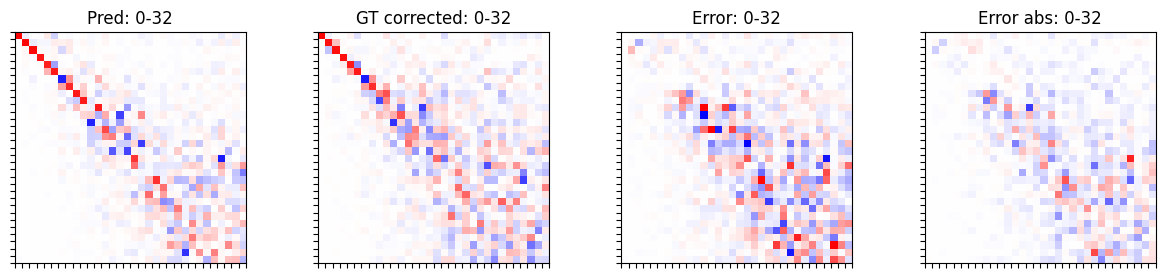

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3))

index_fmap = 7

plotting_utils.plot_Cxy(fig, axs[0], Cxy_est_list[index_fmap],
                        f'Pred', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], C_gt_xy_corr_list[index_fmap],
                        f'GT corrected', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2], Cxy_est_list[index_fmap] - C_gt_xy_corr_list[index_fmap],
                        f'Error', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[3], Cxy_est_list[index_fmap].abs() - C_gt_xy_corr_list[index_fmap].abs(),
                        f'Error abs', l, h, show_grid=False, show_colorbar=False)

print(f'Shape {index_fmap}')
print(f'Geo_err_est: {geo_errs[index_fmap]:.2f}')
print(f'Ratio: {ratios[index_fmap]:.2f}')

plt.show()

# Use zoomout

In [25]:
import utils.fmap_util as fmap_util
import metrics.geodist_metric as geodist_metric
from my_code.sign_canonicalization.training import predict_sign_change
from pyFM_fork.pyFM.refine.zoomout import zoomout_refine


ratios = []
geo_errs = []

iterator = tqdm(range(1, len(test_dataset)))
for i in iterator:

# for i in range(15, 20):

    batch_i = test_dataset[i]
    data_x = batch_i['first']
    data_y = batch_i['second']
    
    Cxy_est = fmap_sampled[i]
    
    
    # remove the channel dimension if it exists
    if len(Cxy_est.shape) == 3:
        Cxy_est = Cxy_est[0]
        C_gt_xy = data_y['C_gt_xy'][0]
    else:
        C_gt_xy = data_y['C_gt_xy']
        
    # unpack the data  
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    verts_first = data_x['verts'].unsqueeze(0).to(device)
    verts_second = data_y['verts'].unsqueeze(0).to(device)
    
    faces_first = data_x['faces'].unsqueeze(0).to(device)
    faces_second = data_y['faces'].unsqueeze(0).to(device)

    evecs_first = data_x['evecs'][:, :model.model.sample_size].unsqueeze(0).to(device)
    evecs_second = data_y['evecs'][:, :model.model.sample_size].unsqueeze(0).to(device)
    
    corr_first = data_x['corr']
    corr_second = data_y['corr']
  
    
    ### get evecs with correct signs
    with torch.no_grad():
        sign_pred_first = predict_sign_change(
            sign_corr_net,
            verts_first, faces_first,
            evecs_first, evecs_cond=None,
            input_type=sign_corr_net.input_type
            )[0]
        sign_pred_second = predict_sign_change(
            sign_corr_net,
            verts_second, faces_second, 
            evecs_second, evecs_cond=None, 
            input_type=sign_corr_net.input_type
            )[0]

    # GT corrected fmap
    C_gt_xy_corr = torch.linalg.lstsq(
        evecs_second.cpu()[0, corr_second] * torch.sign(sign_pred_second).cpu(),
        evecs_first.cpu()[0, corr_first] * torch.sign(sign_pred_first).cpu()
        ).solution 
    
    # sign corrected evecs
    evecs_first_corr = evecs_first.cpu()[0] * torch.sign(sign_pred_first).cpu()
    evecs_second_corr = evecs_second.cpu()[0] * torch.sign(sign_pred_second).cpu()   
    
    evecs_first_corr_full = torch.cat([
        evecs_first_corr, data_x['evecs'][:, model.model.sample_size:]
    ], dim=-1)
    evecs_second_corr_full = torch.cat([
        evecs_second_corr, data_y['evecs'][:, model.model.sample_size:]
    ], dim=-1)
    
    
    Cxy_est_zo = zoomout_refine(
        FM_12=Cxy_est.numpy(), 
        evects1=evecs_first_corr_full.numpy(), 
        evects2=evecs_second_corr_full.numpy(),
        nit=(evecs_first_corr_full.shape[-1] - model.model.sample_size) // 4,
        step=4,
        verbose=False
    )
    Cxy_est_zo = torch.tensor(Cxy_est_zo)
    
    # hard correspondence 
    p2p_gt = fmap_util.fmap2pointmap(
        C12=C_gt_xy,
        evecs_x=data_x['evecs'],
        evecs_y=data_y['evecs'],
        )
    p2p_est = fmap_util.fmap2pointmap(
        Cxy_est,
        evecs_x=evecs_first_corr,
        evecs_y=evecs_second_corr,
        )
    p2p_est_zo = fmap_util.fmap2pointmap(
        Cxy_est_zo,
        evecs_x=evecs_first_corr_full,
        evecs_y=evecs_second_corr_full,
        )
    
    ###################################
    # Finished here, check the above as well
    ###################################
    
    # distance matrices
    dist_x = torch.cdist(data_x['verts'], data_x['verts'])
    dist_y = torch.cdist(data_y['verts'], data_y['verts'])

    # geodesic error
    geo_err_gt = geodist_metric.calculate_geodesic_error(dist_x, data_x['corr'], data_y['corr'], p2p_gt, return_mean=False)  
    geo_err_est = geodist_metric.calculate_geodesic_error(dist_x, data_x['corr'], data_y['corr'], p2p_est, return_mean=False)
    geo_err_est_zo = geodist_metric.calculate_geodesic_error(dist_x, data_x['corr'], data_y['corr'], p2p_est_zo, return_mean=False)
    
    # mse between sampled and corrected fmap
    # mse_fmap = torch.nn.functional.mse_loss(C_gt_xy_corr, Cxy_est)
    mse_fmap = torch.sum((C_gt_xy_corr - Cxy_est) ** 2)
    
    # fig, axs = plt.subplots(1, 5, figsize=(15, 3))

    # plotting_utils.plot_Cxy(fig, axs[0], Cxy_est,
    #                         f'Pred', l, h, show_grid=False, show_colorbar=False)
    # plotting_utils.plot_Cxy(fig, axs[1], Cxy_est_zo,
    #                         f'Zoomout refined', l, h, show_grid=False, show_colorbar=False)
    # plotting_utils.plot_Cxy(fig, axs[2], C_gt_xy_corr,
    #                         f'GT', l, h, show_grid=False, show_colorbar=False)
    # plotting_utils.plot_Cxy(fig, axs[3], Cxy_est - C_gt_xy_corr,
    #                         f'Error', l, h, show_grid=False, show_colorbar=False)
    # plotting_utils.plot_Cxy(fig, axs[4], Cxy_est_zo[:model.model.sample_size, :model.model.sample_size] - C_gt_xy_corr,
    #                         f'Error Zoomout', l, h, show_grid=False, show_colorbar=False)
    
    # print(i)
    # print(f'Geo error GT: {geo_err_gt.mean() * 100:.2f}')
    # print(f'Geo error est: {geo_err_est.mean() * 100:.2f}')
    # print(f'Geo error est zo: {geo_err_est_zo.mean() * 100:.2f}')
    # print(f'MSE fmap: {mse_fmap:.3f}')
    # print(f'MSE abs fmap: {mse_abs_fmap:.3f}')
    
    
    # plt.show()
    
    # print(f'{i:2d}) ratio {geo_err_est.mean() / geo_err_corr_gt.mean():.2f}')
    
    ratios.append(geo_err_est_zo.mean() / geo_err_gt.mean())
    geo_errs.append(geo_err_est_zo.mean() * 100)
    
    iterator.set_postfix({'geo_err': np.mean(geo_errs), 'ratio': np.mean(ratios)})
    # break
    
ratios = torch.tensor(ratios)
geo_errs = torch.tensor(geo_errs)
    
# print mean / median / min / max ratio and geo errs
# ratios
print(f'Mean ratio: {ratios.mean():.2f}')
print(f'Median ratio: {ratios.median():.2f}')
print(f'Min ratio: {ratios.min():.2f}')
print(f'Max ratio: {ratios.max():.2f}')

# geo errs
print(f'Mean geo err: {geo_errs.mean():.2f}')
print(f'Median geo err: {geo_errs.median():.2f}')
print(f'Min geo err: {geo_errs.min():.2f}')
print(f'Max geo err: {geo_errs.max():.2f}')

100%|████████████████████████████████████████████████████████████████████████████| 79/79 [54:59<00:00, 41.76s/it, geo_err=3.19, ratio=6.36]

Mean ratio: 6.36
Median ratio: 4.95
Min ratio: 1.87
Max ratio: 20.27
Mean geo err: 3.19
Median geo err: 2.74
Min geo err: 0.24
Max geo err: 10.12


In [2]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
ax[0].plot(range(1, len(test_dataset)), geo_errs)
ax[0].set_title('Geo error')
    
ax[1].plot(range(1, len(test_dataset)), ratios)
ax[1].set_title('Geo error ratio')

plt.show()

NameError: name 'plt' is not defined